# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




In [3]:
# Import passengers.csv and set it as a time-series object. Plot the TS

passengers = pd.read_csv('passengers.csv')
passengers.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [5]:
passengers.Month = pd.to_datetime(passengers.Month)
passengers.set_index('Month',inplace=True)

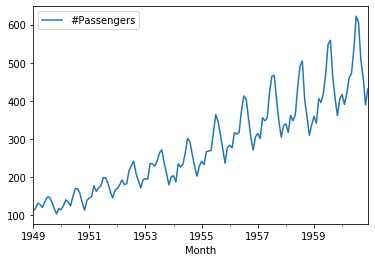

In [6]:
passengers.plot()

## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [22]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab
from statsmodels.tsa.stattools import adfuller

def stationarity_check(ts):
    #Determine rolling statistics
    rolmean = ts.rolling(window=12, center=False).mean()
    rolstd = ts.rolling(window=12, center=False).std()

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(ts, label='data')
    ax.plot(rolmean, label='mean')
    ax.plot(rolstd, label='std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend();

    #Perform Dickey-Fuller test:
    print('Dickey-Fuller test')
    dftest = adfuller(ts['#Passengers'])
    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Use your newly created function on the airpassenger data set.

Dickey-Fuller test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


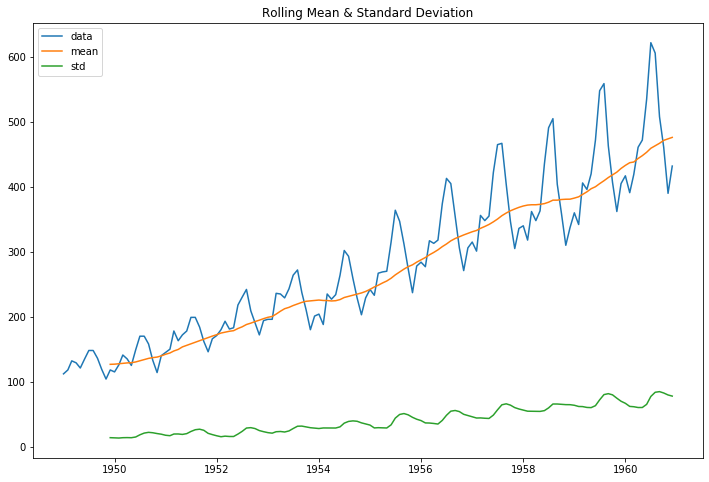

In [23]:
# Code here
stationarity_check(passengers)

## Perform a log() and sqrt() transform

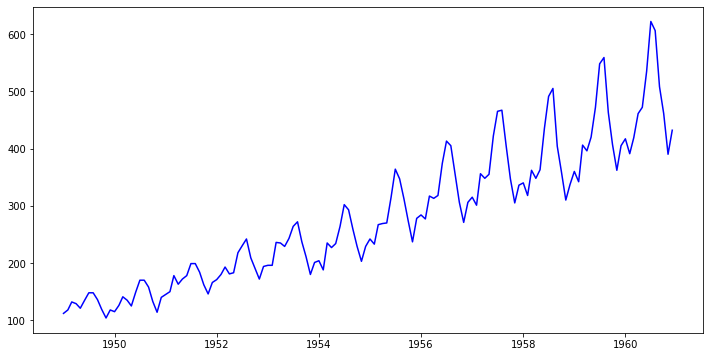

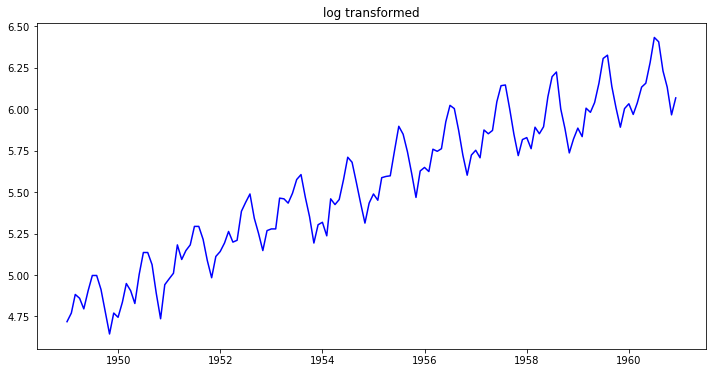

Text(0.5, 1.0, 'square root')

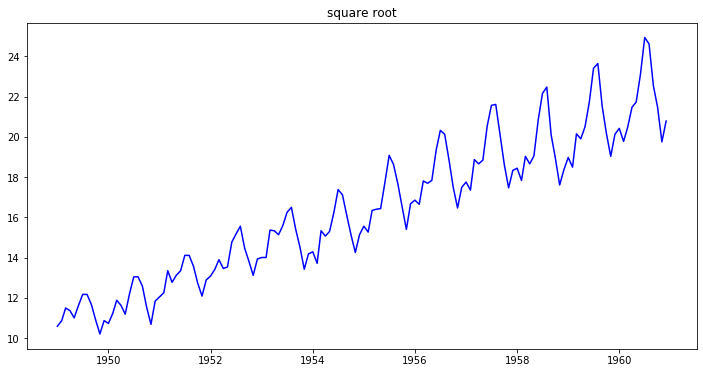

In [25]:
# Log transform timeseries and compare with original to check the effect
ts_log = np.log(passengers)
ts_sqrt= np.sqrt(passengers)
fig = plt.figure(figsize=(12,6))
plt.plot(passengers,  color='blue');
plt.show()
fig = plt.figure(figsize=(12,6))
plt.plot(ts_log, color='blue');
plt.title("log transformed")
plt.show()
fig = plt.figure(figsize=(12,6))
plt.plot(ts_sqrt, color='blue');
plt.title("square root")

moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

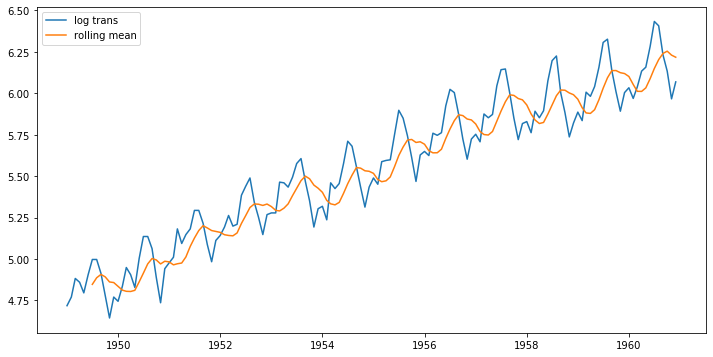

In [28]:
# rolling mean

rolmean = ts_log.rolling(window=7,center=False).mean()

fig,ax = plt.subplots(figsize=(12,6))
plt.plot(ts_log, label='log trans')
plt.plot(rolmean, label='rolling mean')
plt.legend()

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [29]:
# Subtract the moving average from the original data and check head for Nans
data_minus_rolmean = ts_log - rolmean
data_minus_rolmean.head(10)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,0.150059
1949-08-01,0.110242
1949-09-01,0.005404


In [30]:
# Drop the NaN values from timeseries calculated above
data_minus_rolmean.dropna(inplace=True)

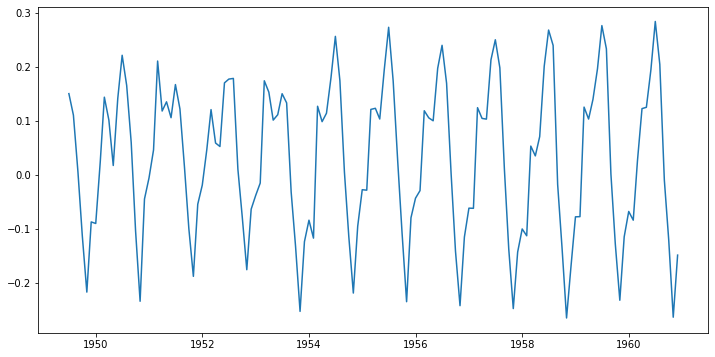

In [31]:
# Plot the result
fig = plt.figure(figsize=(12,6))
plt.plot(data_minus_rolmean);
                 

Finally, use your function `check_stationarity` to see if this series is considered stationary!

Dickey-Fuller test
Test Statistic                  -2.348027
p-value                          0.156946
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


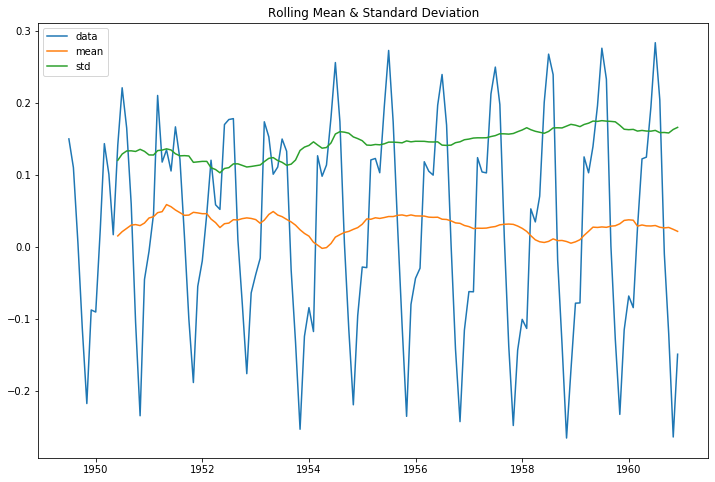

In [33]:
# Your code here
stationarity_check(data_minus_rolmean)


### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


In [34]:
# Your conclusion here
# The data is not stationary, based on the dickey-fulller test

## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

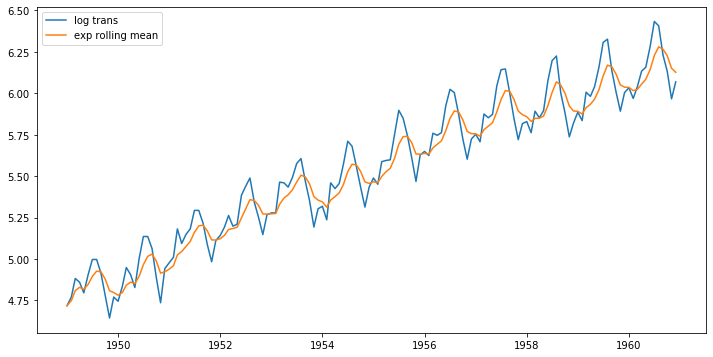

In [35]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log

exp_rolmean = ts_log.ewm(halflife=2).mean()

# Plot the original data with exp weighted average
fig,ax = plt.subplots(figsize=(12,6))
plt.plot(ts_log, label='log trans')
plt.plot(exp_rolmean, label='exp rolling mean')
plt.legend()

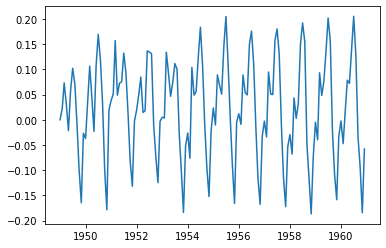

In [36]:
# Subtract the moving average from the original data and plot

data_minus_exprol = ts_log - exp_rolmean

plt.plot(data_minus_exprol)

Dickey-Fuller test
Test Statistic                  -3.087696
p-value                          0.027477
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


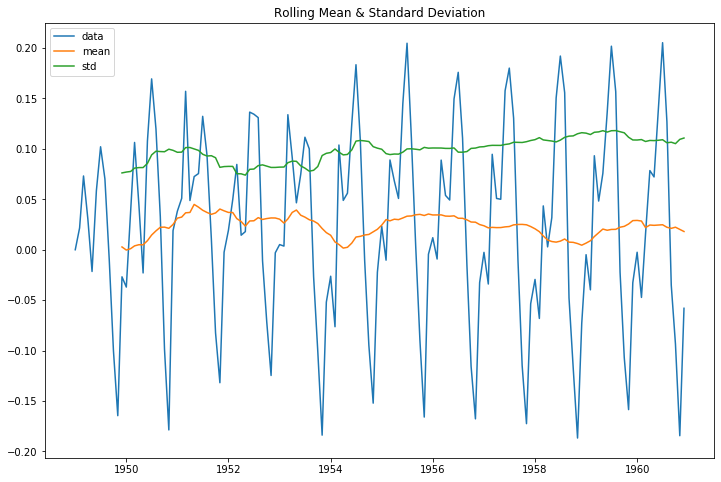

In [37]:
# do a stationarity check
stationarity_check(data_minus_exprol)


### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


In [38]:
# Your conclusion here

# The data is stationary based on the visuals and the dickey-fuller test

## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [41]:
# difference your data and look at the head

ts_dif = ts_log.diff(periods=12)
ts_dif.head(18)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


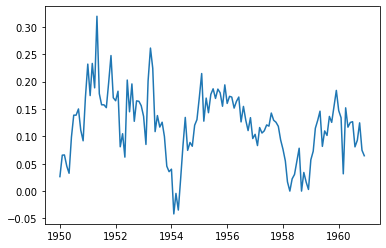

In [42]:
# plot your differenced time series

plt.plot(ts_dif)

In [44]:
# drop nas
ts_dif.dropna(inplace=True)

Dickey-Fuller test
Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


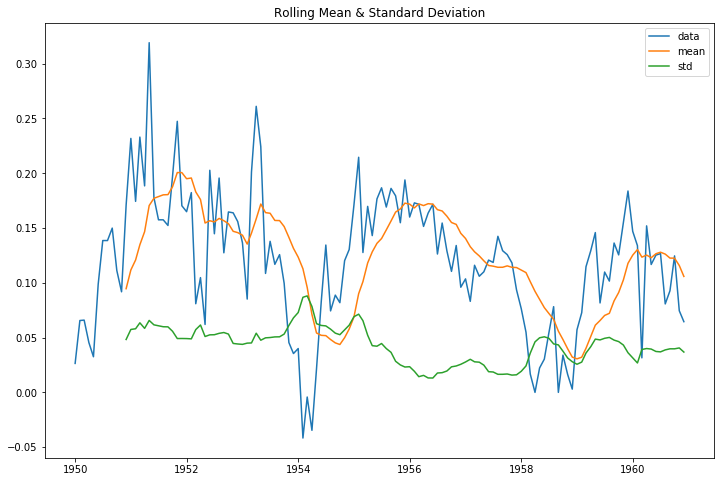

In [45]:
# perform the stationarity check

stationarity_check(ts_dif)

### Your conclusion

In [46]:
# Your conclusion here

# The data is stationary, and the seasonality is gone

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.